### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [3]:
transform2 = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),          
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],      
        std=[0.5, 0.5, 0.5]         
    )
])

In [4]:
dataset = datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform2)

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [6]:
indices = list(range(len(dataset)))

In [7]:
split = int(np.floor(0.70 * len(dataset)))  # train_size

In [8]:
validation = int(np.floor(0.60 * split))  # validation

In [119]:
data_transforms = {
    'split': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
         transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
}

AttributeError: 'Compose' object has no attribute 'Compose'

In [9]:
print(0, validation, split, len(dataset))

0 1585 2643 3777


In [10]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :1585
length of validation size :1058
length of test size :2192


In [11]:
np.random.shuffle(indices)

### Split into Train and Test

In [12]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [13]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [14]:
targets_size = len(dataset.class_to_idx)
print(targets_size)

50


In [15]:
num_classes_list = list(dataset.class_to_idx.values())
print(num_classes_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [16]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [34]:
model2 = models.inception_v3(pretrained=True)

In [17]:
for params in model.parameters():
   params.requires_grad = False

In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
n_features = model.classifier[0].in_features
n_features

25088

In [20]:
model.classifier = nn.Sequential(
     nn.Linear(n_features, 1024),
     nn.ReLU(),
     nn.Dropout(0.4),
     nn.Linear(1024, targets_size),
 )

### Original Modeling

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [24]:
from torchsummary import summary
 
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 299, 299]           1,792
              ReLU-2         [-1, 64, 299, 299]               0
            Conv2d-3         [-1, 64, 299, 299]          36,928
              ReLU-4         [-1, 64, 299, 299]               0
         MaxPool2d-5         [-1, 64, 149, 149]               0
            Conv2d-6        [-1, 128, 149, 149]          73,856
              ReLU-7        [-1, 128, 149, 149]               0
            Conv2d-8        [-1, 128, 149, 149]         147,584
              ReLU-9        [-1, 128, 149, 149]               0
        MaxPool2d-10          [-1, 128, 74, 74]               0
           Conv2d-11          [-1, 256, 74, 74]         295,168
             ReLU-12          [-1, 256, 74, 74]               0
           Conv2d-13          [-1, 256, 74, 74]         590,080
             ReLU-14          [-1, 256,

In [25]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [26]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for e in range(epochs):

        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
           
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())  # torch to numpy world
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss

        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Duration:{dt}")

    return train_losses

In [27]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [28]:
train_losses = batch_gd(model, criterion, train_loader, validation_loader, 10)

Epoch : 1/10 Train_loss:2.314 Duration:0:02:00.248449
Epoch : 2/10 Train_loss:0.288 Duration:0:01:33.620912
Epoch : 3/10 Train_loss:0.083 Duration:0:01:34.667250
Epoch : 4/10 Train_loss:0.040 Duration:0:01:36.910294
Epoch : 5/10 Train_loss:0.018 Duration:0:01:34.730755
Epoch : 6/10 Train_loss:0.011 Duration:0:01:34.883135
Epoch : 7/10 Train_loss:0.009 Duration:0:01:35.401162
Epoch : 8/10 Train_loss:0.006 Duration:0:01:36.439084
Epoch : 9/10 Train_loss:0.004 Duration:0:01:34.218968
Epoch : 10/10 Train_loss:0.003 Duration:0:01:34.404970


### Save the Model

### Load Model

In [ ]:
targets_size = 50
model = CNN(targets_size)
model.load_state_dict(torch.load("plant.pt"))
model.eval()

In [ ]:
# %matplotlib notebook

### Plot the loss

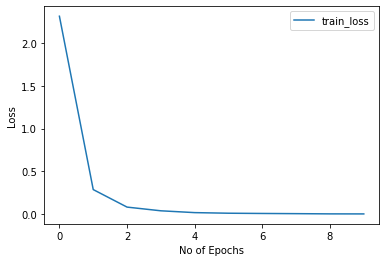

In [29]:
plt.plot(train_losses , label = 'train_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [31]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        #print(outputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [32]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [33]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 1.0
Test Accuracy : 0.8747795414462081
Validation Accuracy : 0.8790170132325141


In [35]:
torch.save(model, "PlantMed.pt")

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = torch.load("PlantMed.pt", map_location=device)
loaded_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
from PIL import Image

In [38]:
transforms = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),          
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],      
        std=[0.5, 0.5, 0.5]         
    )
])

In [103]:
image_path = "/kaggle/input/thatlittleplant/LittlePlant.webp"  
image = Image.open(image_path)

(-0.5, 1023.5, 767.5, -0.5)

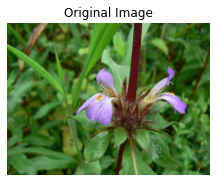

In [104]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

In [105]:
input_data = transforms(image).unsqueeze(0).to(device)

In [106]:
with torch.no_grad():
    output = loaded_model(input_data)

In [107]:
_, predicted_class = output.max(1)

In [108]:
predicted_class

tensor([22], device='cuda:0')

In [110]:
class_to_idx = dataset.class_to_idx 
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
index = 22
class_name = idx_to_class.get(index, "Unknown")  

print(f"Class name for index {index}: {class_name}")

Class name for index 22: Kokilaksha.zip
